In [ ]:
!pip install kaggle
from google.colab import files 
#files.open('/content/drive/MyDrive/Colab Notebooks/json kaggle')
files.upload() #download and upload json file



!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d samratalam/stemmed-20-times-dataset

100% 62.0M/62.2M [00:00<00:00, 52.4MB/s]
100% 62.2M/62.2M [00:00<00:00, 71.3MB/s]


In [ ]:
#to unzip file

from zipfile import ZipFile
file_name= "stemmed-20-times-dataset.zip"

with ZipFile(file_name ,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
#from unidecode import unidecode
import os
from time import time 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [ ]:
'''
!pip install wandb
import wandb
wandb.init()
'''

'\n!pip install wandb\nimport wandb\nwandb.init()\n'

In [ ]:
df=pd.read_csv('/content/strem_20_times_data_clen.csv')

df.drop(columns=['Unnamed: 0'],inplace=True)
display(df)

,Sentence,Sentiment,length
0,গ্রেগর সামসা সেলস্ম্যান সকাল ঘুম উঠ তেলাপোকা ব...,2,45477
1,গ্রেগর সামসা সেলস্ম্যান সকাল ঘুম উঠ তেলাপোকা ব...,1,45477
2,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,4,33176
3,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,8,33176
4,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,9,33176
...,...,...,...
95757,ঢাকা সেপ্ট,4,10
95758,মারুফ মল্,6,9
95759,মারুফ মল্,6,9
95760,লਫন৴ োম,2,7


In [ ]:
df.iloc[95119]['Sentence']

'প্রি শিক্ষার্থী ইংরেজি পত্র নং প্রশ্ন প্রশ্ন শূন্যস্থান পূরণ নম্বর প্রভাষক ঢাকা রেসিডেনসিয়াল মড কলেজ'

# **Dataframe Null value **

In [ ]:
df.loc[df['length'] <= 100]

,Sentence,Sentiment,length
95117,ইংরেজি পত্র লেসন প্রি শিক্ষার্থী ইংরেজি পত্র ল...,4,100
95118,প্রি শিক্ষার্থী ইংরেজি পত্র নম্বর প্রশ্ন আলোচন...,4,100
95119,প্রি শিক্ষার্থী ইংরেজি পত্র নং প্রশ্ন প্রশ্ন শ...,4,100
95120,প্রি শিক্ষার্থী ইংরেজি পত্র চর্চা কর মি নেব শি...,4,100
95121,রিয়াজুল বাশ মাহমুদ শরীফ বিডিনিউজ টোয়েন্টিফোর ড...,6,100
...,...,...,...
95757,ঢাকা সেপ্ট,4,10
95758,মারুফ মল্,6,9
95759,মারুফ মল্,6,9
95760,লਫন৴ োম,2,7


In [ ]:
df.drop(df[df['length'] < 100].index, inplace = True)
display(df)

,Sentence,Sentiment,length
0,গ্রেগর সামসা সেলস্ম্যান সকাল ঘুম উঠ তেলাপোকা ব...,2,45477
1,গ্রেগর সামসা সেলস্ম্যান সকাল ঘুম উঠ তেলাপোকা ব...,1,45477
2,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,4,33176
3,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,8,33176
4,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,9,33176
...,...,...,...
95125,জয়পুর জুন বিডিনিউজ টোয়েন্টিফোর ডটকমরয়টার্স চাক...,4,100
95126,ইউনিট লেসন প্রি শিক্ষার্থী ইংরেজি পত্র গতকাল ই...,4,100
95127,ইউনিট লেসন প্রিয় শিক্ষার্থী ইংরেজি পত্র ইউনিট...,4,100
95128,প্রি শিক্ষার্থী ইংরেজি পত্র নং প্রশ্ন আলোচনা ...,4,100


In [ ]:
df = df.drop_duplicates('Sentence', keep='first')
df.drop(df[df['Sentiment']==1 ].index, inplace = True)
df.drop(df[df['Sentiment']==8 ].index, inplace = True)
df.reset_index(inplace=True)
df.drop(columns=['index'],inplace=True)
df

,Sentence,Sentiment,length
0,গ্রেগর সামসা সেলস্ম্যান সকাল ঘুম উঠ তেলাপোকা ব...,2,45477
1,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,4,33176
2,এটিএন বাংলা ঈদ অনুষ্ঠানমালা ছয়দিন দশ পর্ব নাটক...,11,26534
3,কথা কথা কথা পাব অ্যাকটিং ভালো রপ্ত কর ওশোর পাত...,11,21860
4,উত্থান পর্ব সাল ফেব্রুয়ারি মাস বাংলাদেশ প্রজন্...,2,21460
...,...,...,...
78820,জয়পুর জুন বিডিনিউজ টোয়েন্টিফোর ডটকমরয়টার্স চাক...,4,100
78821,ইউনিট লেসন প্রি শিক্ষার্থী ইংরেজি পত্র গতকাল ই...,4,100
78822,ইউনিট লেসন প্রিয় শিক্ষার্থী ইংরেজি পত্র ইউনিট...,4,100
78823,প্রি শিক্ষার্থী ইংরেজি পত্র নং প্রশ্ন আলোচনা ...,4,100


In [ ]:
df.isna().sum().sum()

0

In [ ]:
df.dropna(axis=0, how="any", thresh=None, subset=None, inplace=True)

In [ ]:
df.isna().sum().sum()

0

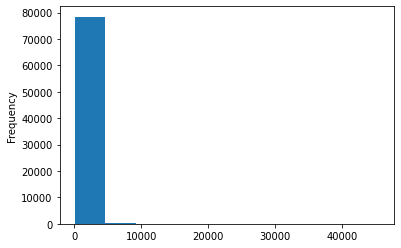

In [ ]:
df['Sentence'].apply(lambda x: len(str(x))).plot(kind='hist');

In [ ]:
df.Sentiment.reset_index(drop=True, inplace=True)

In [ ]:
df.Sentiment.value_counts()

9     18558
11    11296
4     10706
5      8951
2      8199
0      6126
7      5036
6      3754
3      3389
10     2810
Name: Sentiment, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


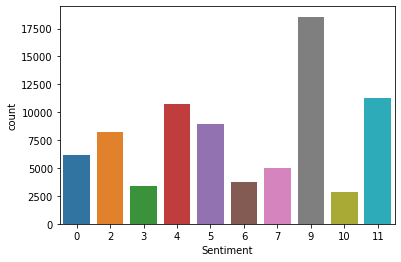

In [ ]:
sns.countplot(df['Sentiment']);

# **bnltk 0.7.6 Stemmer**

**New Stemmed**

In [ ]:
uniqueWords = list(set(" ".join(df['Sentence']).split(" ")))
count = len(uniqueWords)
print(count)

271263


In [ ]:
df['Sentence'] = df['Sentence'].astype('str') 
df.reset_index(drop=True, inplace=True)
#df['Sentence'] = df['Sentence'].astype('str')

In [ ]:

#df['Sentence'] = df.Sentence.apply(lambda x: Stemming(str(x)))

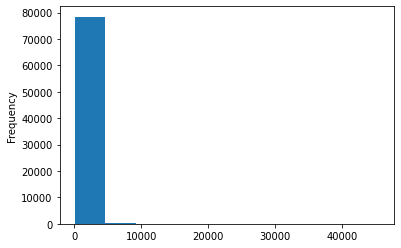

In [ ]:
df['Sentence'].apply(lambda x: len(str(x))).plot(kind='hist');

In [ ]:
from collections import Counter
#Counter(" ".join(df["Sentence"]).split()).most_common(1000)  
#NOT FASTER 

In [ ]:
#pd.Series(' '.join(df['Sentence']).lower().split()).value_counts()[:10000] #faster AND for large amounts of text/rows

# **Shuffle the data**

In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)

In [ ]:
df.Sentiment.value_counts()

9     18558
11    11296
4     10706
5      8951
2      8199
0      6126
7      5036
6      3754
3      3389
10     2810
Name: Sentiment, dtype: int64

In [ ]:
train1, test1 = train_test_split(df,random_state=22, test_size=0.2)
training_sentences = []
testing_sentences = []




train_sentences=train1['Sentence'].values
train_labels=train1['Sentiment'].values
#for i in range(train_sentences.shape[0]): 
    #print(train_sentences[i])
 #   x=str(train_sentences[i])
 #   training_sentences.append(x)

 
    
#training_sentences=np.array(training_sentences)





test_sentences=test1['Sentence'].values
test_labels=test1['Sentiment'].values
#y = pd.get_dummies(data1['Sentiment']).values

train_labels=pd.get_dummies(train_labels).values
test_labels=pd.get_dummies(test_labels).values


print("Training Set Length: "+str(len(train1)))
print("Testing Set Length: "+str(len(test1)))
print("training_sentences shape: "+str(train_sentences.shape))
print("testing_sentences shape: "+str(test_sentences.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))


Training Set Length: 63060
Testing Set Length: 15765
training_sentences shape: (63060,)
testing_sentences shape: (15765,)
train_labels shape: (63060, 10)
test_labels shape: (15765, 10)


In [ ]:
train_labels

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

In [ ]:
print(train_sentences[10])
print(train_labels[0])

ঢাকায় রায়পুর উপজেলা পৌর বিএনপির আংশিক কমি গঠন কমি সম্পাদক সাংগঠনিক সম্পাদক পদ একাধিক প্রার্থী সংঘর্ষ আশঙ্কায় ঢাকায় কমি গঠন জেলা কমি দলীয় সূত্র মঙ্গলব রায়পুর জেলা পরিষদ মিলনায়তন উপজেলা পৌর বিএনপির সম্মেলন উপজেলা বিএনপির সভাপতি মনিরুল ইসলাম হাওলাদ পৌর বিএনপির সভাপতি এম জিলানী প্রতিদ্বন্দ্বিতায় নির্বাচিত সম্পাদক সাংগঠনিক সম্পাদক নেতা নির্বাচন চূড়ান্ত তড়িঘড়ি সম্মেলন সম্মেলন প্রধান অতিথি লক্ষ্মীপুর রায়পুর আসন সাংসদ জেলা বিএনপির সভাপতি আবুল খায় ভূঁইয়া উপস্থিত হননি দলীয় সূত্র শুক্র স্থানীয় নেতাকর্মী ঢাকায় মহানগর বিএনপির কার্যালয় জড়ো দুপুর রাত সমঝোতা বৈঠক জেলা বিএনপির সভাপতি আবুল খায় ভূঁইয়া বৈঠ উপস্থিত সমঝোতা উপজেলা বিএনপির সম্পাদক পদ পাঁচজন প্রার্থী প্রতিদ্বন্দ্বিতা কাউন্সিলর ভোট উপজেলা বিএনপির সম্পাদক পদ নাজমুল ইসলাম মিঠু সাংগঠনিক সম্পাদক পদ মোবারক হোস মাস্ নির্বাচিত পৌর বিএনপির সম্পাদক পদ এম জাহ সাংগঠনিক সম্পাদক পদ দেলোয় হোস নির্বাচিত কয়েকজন জ্যেষ্ঠ নেতা জানান উপজেলা পৌর বিএনপির সম্পাদক সাংগঠনিক সম্পাদক পদ চারছয়জন প্রার্থী প্রতিদ্বন্দ্বিতা প্রার্থী সমর্থক নেতাকর্মী স

In [ ]:
vocab_size = 200000
embedding_dim = 300
max_length = 4000
trunc_type='post'
oov_tok = "<OOV>"

In [ ]:
print(train_sentences.shape)
print(train_labels.shape)

(63060,)
(63060, 10)


In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

#451606 words in raw dataset
#434245 words in raw dataset after stopwords removal
#339313 after stemming 

print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)


test_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

238622
Word index length:238622


In [ ]:
print("Sentence :--> \n")
print(train_sentences[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[2])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[2])

Sentence :--> 

প্রয়াত অভিনেতা হুমায়ূন ফরিদীর সেলুলয়েড খলনায়ক হাসা থিতু চাইছ শতাব্দী চোখ চলচ্চিত্র সা গ্লিটজ আলাপচারিতা শতাব্দী খলচরিত্র অভিন সুযোগ সিনেমা অভিন চরিত্র সবচা গুরুত্বপূর্ণ সিনেমা দৃশ্য অভিন অনুঘটক ভূমিকা থাক কোনো আপত্তি অভিনেতা অভিন সুযোগ অভিন কর জীবনঢুলী বাপজান বায়োস্কোপএর সিনেমা ভূমিকা অভিন সিনেমা শতাব্দী বলছ তথাকথিত নায়ক গল্প নায়ক হাসা উপস্থাপন শতাব্দী চোখ দেখ সিনেমা আলোচনা চল নাট্যদল প্রাচ্যনাট সিনিয়র অভিনেতা শিল্পী প্রসঙ্গ ধৈযর্্যশক্তি একেব থি অভিন ট্যাবলেটক্যাপসুল খা বিষ রাতারাতি অভিনেতা প্রতিনিয়ত অনুশীলন সেজন্য প্রয়োজন প্রচুর সম ব্য এখনক সম থি আস অনুশীলন সম অল্প সম পাতা ক্ষেত্র অভিন চরিত্র শহর চরিত্র অভিন গ্রাম চরিত্র অভিন গ্রাম পারল শহর সিনিয়র অভিন শিল্পী ক্ষেত্র সিনেমা ব্যস্তত পাশাপাশি টিভি নাট নিয়মিত অভিন শতাব্দী ওয়াদুদ অভিন অম্লান বিশ্বাস অনন্যা রুলিন রহমান দহন নাহিদ বাবুর দহন বেলা ধারাবাহি অভিনেতা হাসা স্বপ্ন কথা গ্লিটজ জীবন অস্ক পুরস্ক হা গালিচা হাঁট চা

Sentence Tokenized and Converted into Sequence :--> 

[1396, 935, 1932, 54330, 28744, 9566, 34, 7636, 4096

In [ ]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Padded shape(training): (63060, 4000)
Padded shape(testing): (15765, 4000)


In [ ]:
model= Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
#model.add(Conv1D(200, kernel_size=3, activation = "relu"))
#model.add(Bidirectional(LSTM(64, return_sequences=True)))
#model.add(Dropout(0.5))
#model.add(Bidirectional(LSTM(64)))
#model.add(Flatten())
model.add(Dense(400, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
#model.add(Flatten())
#l2 regularizer
model.add(Dense(20,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
#model.add(Flatten())
model.add(Dense(10, activation='softmax'))
#sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
adam=Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

#ANN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4000, 300)         60000000  
_________________________________________________________________
dense (Dense)                (None, 4000, 400)         120400    
_________________________________________________________________
dense_1 (Dense)              (None, 4000, 100)         40100     
_________________________________________________________________
dense_2 (Dense)              (None, 4000, 100)         10100     
_________________________________________________________________
flatten (Flatten)            (None, 400000)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                20000050  
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2

In [ ]:
history=model.fit(padded,train_labels,epochs=5,batch_size=128,validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=8)

Epoch 1/5
493/493 [==============================] - 499s 980ms/step - loss: 1.6916 - accuracy: 0.4818 - val_loss: 0.7501 - val_accuracy: 0.8143
Epoch 2/5
493/493 [==============================] - 482s 978ms/step - loss: 0.5497 - accuracy: 0.8707 - val_loss: 0.6140 - val_accuracy: 0.8482
Epoch 3/5
493/493 [==============================] - 482s 979ms/step - loss: 0.3092 - accuracy: 0.9325 - val_loss: 0.6596 - val_accuracy: 0.8462
Epoch 4/5
493/493 [==============================] - 480s 973ms/step - loss: 0.1932 - accuracy: 0.9630 - val_loss: 0.7400 - val_accuracy: 0.8406
Epoch 5/5
493/493 [==============================] - 479s 971ms/step - loss: 0.1338 - accuracy: 0.9772 - val_loss: 0.8531 - val_accuracy: 0.8396


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


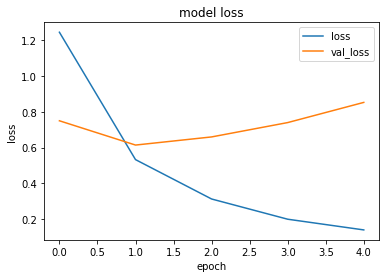

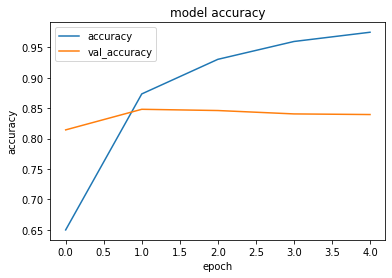

In [ ]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
#accuracy calculation
loss_and_metrics = model.evaluate(padded,train_labels,batch_size=128)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(testing_padded,test_labels,batch_size=128)
print("The test accuracy is: "+str(loss_and_metrics[1]))

493/493 [==============================] - 88s 178ms/step - loss: 0.0946 - accuracy: 0.9883
The train accuracy is: 0.9883285760879517
124/124 [==============================] - 22s 177ms/step - loss: 0.8531 - accuracy: 0.8396
The test accuracy is: 0.8395813703536987


In [ ]:
predictions = model.predict(testing_padded)
pred1 = np.argmax(predictions , axis=1)

In [ ]:
%%time
score = model.evaluate(testing_padded, test_labels , batch_size = 128)
print()

print("ACCURACY:",score[1])
print("LOSS:",score[0])

124/124 [==============================] - 22s 176ms/step - loss: 0.8531 - accuracy: 0.8396

ACCURACY: 0.8395813703536987
LOSS: 0.8530522584915161
CPU times: user 15.5 s, sys: 393 ms, total: 15.9 s
Wall time: 21.9 s


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
test_labels = np.argmax(test_labels,axis=1)

In [ ]:
print(confusion_matrix(test_labels , pred1 ,normalize=None))

[[1018   79    5    3    1    5   26   28    5    3]
 [  52 1353    4   14   35    8   32   95    4   37]
 [   2    5  542    2   10   18   41   28   26    0]
 [   2   42    1 1708   55   97    2  153    4   87]
 [   2   44   16   27 1559   36   38   40    2   41]
 [   6   21   28   52   40  502   10   61   15    5]
 [  17   40   54    2   43    7  831   18    6    5]
 [  29  102   22  130   33   87   28 3224   51   12]
 [   3    6   57    4   20   37    8   25  409    1]
 [   4   62    0   49   43    6    9   14    0 2090]]


In [ ]:
print(classification_report(test_labels , pred1))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1173
           1       0.77      0.83      0.80      1634
           2       0.74      0.80      0.77       674
           3       0.86      0.79      0.82      2151
           4       0.85      0.86      0.86      1805
           5       0.63      0.68      0.65       740
           6       0.81      0.81      0.81      1023
           7       0.87      0.87      0.87      3718
           8       0.78      0.72      0.75       570
           9       0.92      0.92      0.92      2277

    accuracy                           0.84     15765
   macro avg       0.81      0.82      0.81     15765
weighted avg       0.84      0.84      0.84     15765



In [ ]:
accuracy_score(test_labels , pred1)

0.839581351094196